# HMM and Reinforcement Learning Experiments

This notebook demonstrates advanced experiments for the **Probabilistic Stock Trading Agent** project. In this notebook, we:

1. **HMM Integration:**
   - Fit a Gaussian HMM on selected technical indicators (MA, RSI, MACD) to infer latent market regimes.
   - Visualize the inferred market regimes for a subset of observations.
   - Compare the effect of different numbers of latent states.

2. **Reinforcement Learning (Q-Learning):**
   - Implement a Q-learning agent in a simple trading environment using processed data with discretized features and inferred market regimes.
   - Plot the agent's learning curve over multiple episodes.

These experiments help validate the advanced feature engineering and modeling improvements introduced in Milestone 3.

In [31]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from technical_indicators import add_technical_indicators
from hmm_integration import fit_hmm_on_indicators
from rl_agent import QLearningAgent, SimpleTradingEnv
from hmmlearn.hmm import GaussianHMM

# Set random seed for reproducibility
np.random.seed(42)


## 1. HMM Integration Experiment

In this section, we load our processed data, ensure that technical indicators are computed, and fit a Gaussian HMM on selected technical indicators. We then add the inferred latent market regime as a new feature (`Market_Regime`) and visualize the results.

Processed Data Shape: (93593, 17)
Data shape for HMM fitting (after dropping NaNs): (93593, 17)


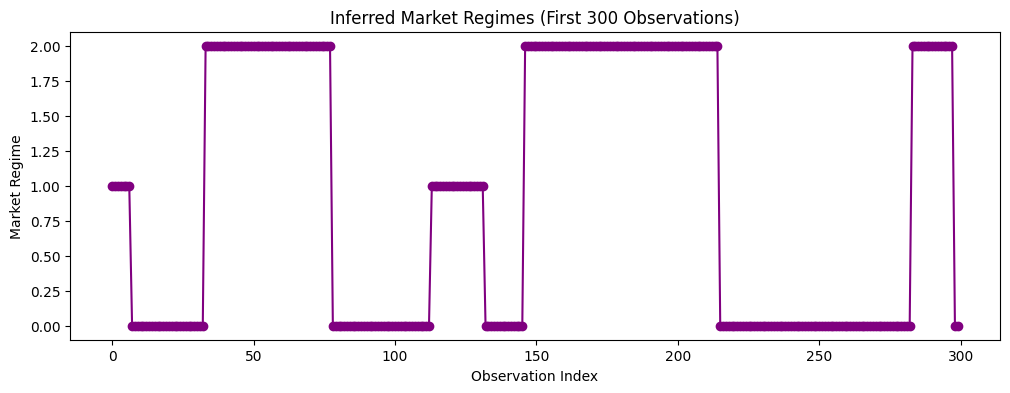

Comparing latent state counts for different configurations:
Number of States: 2 -> State Counts: {np.int64(0): np.int64(21368), np.int64(1): np.int64(72225)}
Number of States: 3 -> State Counts: {np.int64(0): np.int64(40787), np.int64(1): np.int64(10204), np.int64(2): np.int64(42602)}
Number of States: 4 -> State Counts: {np.int64(0): np.int64(6523), np.int64(1): np.int64(33076), np.int64(2): np.int64(27059), np.int64(3): np.int64(26935)}


In [32]:
# Load processed data
processed_file = '../data/processed/all_stocks_2006-01-01_to_2018-01-01.csv'
df = pd.read_csv(processed_file)
print(f"Processed Data Shape: {df.shape}")

# Ensure technical indicators are present; if not, add them
required_indicators = ['MA_20', 'RSI_14', 'MACD']
for indicator in required_indicators:
    if indicator not in df.columns:
        df = add_technical_indicators(df)

# Drop rows with missing values in the required indicator columns
df_hmm = df.dropna(subset=required_indicators).copy()
print(f"Data shape for HMM fitting (after dropping NaNs): {df_hmm.shape}")

# Fit HMM on the selected technical indicators
X = df_hmm[required_indicators].values
n_components = 3  # Based on our experiments, 3 states provide the best balance
hmm_model = GaussianHMM(n_components=n_components, covariance_type='diag', n_iter=100, random_state=42)
hmm_model.fit(X)
latent_states = hmm_model.predict(X)
df_hmm['Market_Regime'] = latent_states

# Plot the inferred Market_Regime for the first 300 observations
plt.figure(figsize=(12, 4))
plt.plot(df_hmm.index[:300], df_hmm['Market_Regime'][:300], marker='o', linestyle='-', color='purple')
plt.xlabel('Observation Index')
plt.ylabel('Market Regime')
plt.title('Inferred Market Regimes (First 300 Observations)')
plt.show()

# Compare different latent state configurations by printing state counts
print("Comparing latent state counts for different configurations:")
for n in [2, 3, 4]:
    model = GaussianHMM(n_components=n, covariance_type='diag', n_iter=100, random_state=42)
    model.fit(X)
    states = model.predict(X)
    unique, counts = np.unique(states, return_counts=True)
    print(f"Number of States: {n} -> State Counts: {dict(zip(unique, counts))}")


## 2. Reinforcement Learning (Q-Learning) Experiment

In this section, we use our processed data (which includes discretized features and the inferred `Market_Regime`) to simulate a simple trading environment. A Q-learning agent is then trained in this environment using an epsilon-greedy policy. The cumulative rewards for each episode are recorded and plotted to create a learning curve.

RL Data Shape: (93593, 17)
Episode 1: Total Reward = -0.04270703304835813
Episode 2: Total Reward = 0.033831357590115685
Episode 3: Total Reward = 0.0025437859037755473
Episode 4: Total Reward = -0.0018435601147144265
Episode 5: Total Reward = 0.013798321280217185
Episode 6: Total Reward = 0.03385965093368329
Episode 7: Total Reward = 0.04305956509301226
Episode 8: Total Reward = 0.050202639115338815
Episode 9: Total Reward = 0.05011568357651938
Episode 10: Total Reward = 0.09638903973397997
Episode 11: Total Reward = 0.048735083745694185
Episode 12: Total Reward = 0.04911487154547148
Episode 13: Total Reward = 0.01354949250715115
Episode 14: Total Reward = 0.10489765919053876
Episode 15: Total Reward = 0.02531342993928337
Episode 16: Total Reward = 0.035354983550892116
Episode 17: Total Reward = 0.032128341141966665
Episode 18: Total Reward = 0.041039078372958976
Episode 19: Total Reward = 0.030055761668881242
Episode 20: Total Reward = 0.032329127868747226
Episode 21: Total Reward = 

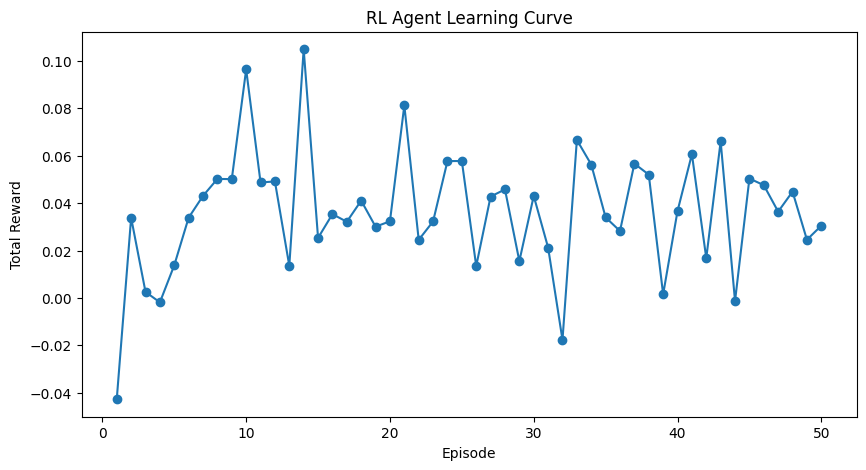

In [33]:
# For RL, select a subset of the processed data that has the required features
rl_features = ['Open_binned', 'High_binned', 'Low_binned', 'Market_Regime']
df_rl = df.dropna(subset=rl_features).copy()
print(f"RL Data Shape: {df_rl.shape}")

# For faster simulation, take a sample of the data
df_rl_sample = df_rl.head(500).reset_index(drop=True)

# Initialize the simple trading environment
env = SimpleTradingEnv(df_rl_sample)

# Initialize the Q-learning agent
agent = QLearningAgent(alpha=0.1, gamma=0.95, epsilon=0.1)

# Simulate multiple episodes and record total rewards
episodes = 50
episode_rewards = []
for ep in range(episodes):
    total_reward = agent.simulate_episode(env, max_steps=100)
    episode_rewards.append(total_reward)
    print(f"Episode {ep+1}: Total Reward = {total_reward}")

# Plot the RL agent learning curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, episodes+1), episode_rewards, marker='o', linestyle='-')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('RL Agent Learning Curve')
plt.show()


## Conclusion

In this notebook we:

- **HMM Integration:** Fitted a Gaussian HMM on technical indicators (MA, RSI, MACD) to infer latent market regimes and visualized the regimes for the first 300 observations. We also compared state configurations to determine an optimal number of latent states.

- **RL Q-Learning:** Implemented a simple Q-learning agent in a simulated trading environment using processed data (with discretized features and the `Market_Regime`). The learning curve shows the cumulative reward per episode, demonstrating the agent’s capability to learn over time.

These experiments validate the integration of advanced models into our project and provide a foundation for future improvements, such as more sophisticated RL methods or dynamic HMM transitions.